## QUESTION:
ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction

In [27]:
#restart the kernel after installation
!pip install pandas-profiling --quiet

In [28]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [29]:
from urllib.request import urlretrieve

In [30]:
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x1a8a15bae50>)

In [31]:
import pandas as pd

In [32]:
medical_df = pd.read_csv('medical.csv')

In [33]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [34]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


It appears "age", "children", "bmi" (body mass index) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [35]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. 
The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

## Exploratory Analysis and Visualization

here we examine relationships within the distribution across the dataset. 
we use the following libraries: Matplotlib, Seaborn and Plotly for visualization. Follow these tutorials to learn how to use these libraries: 


In [36]:
!pip install plotly matplotlib seaborn --quiet

In [37]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following settings will improve the default style and font sizes for our charts.

In [38]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age: Univariate Analysis

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. 
Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. 
We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [39]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

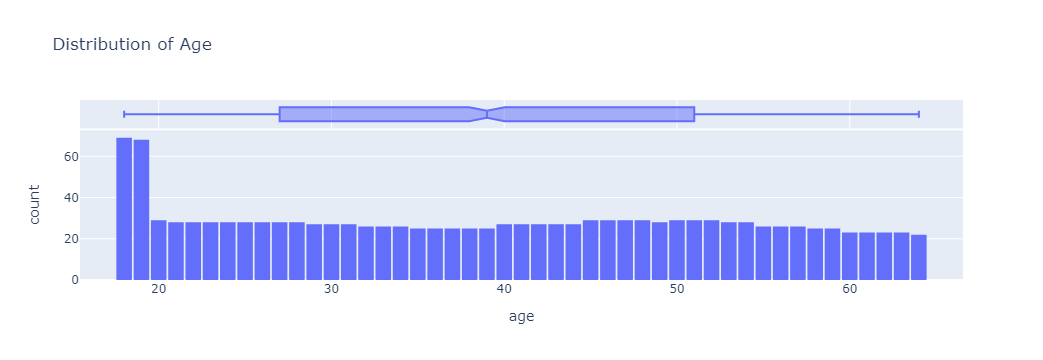

In [40]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)


The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19,
which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.


### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

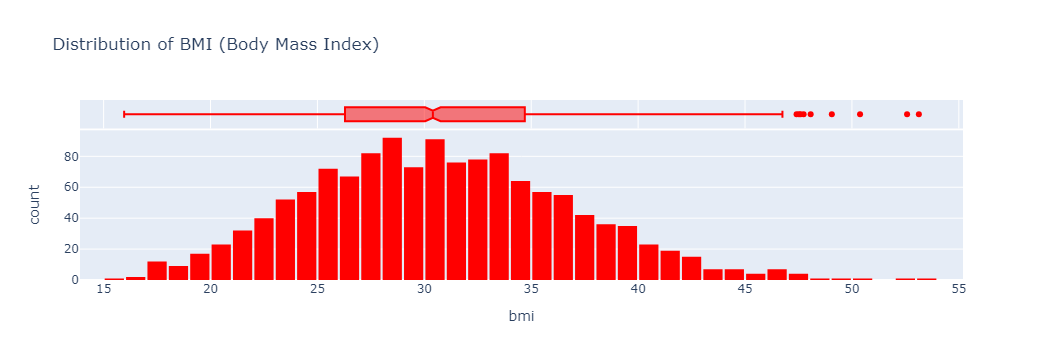

In [41]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a Gaussian distribution centered around the value 30, with a few outliers towards the right. 

### Charges: Bivariate Analysis 

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [42]:
medical_df.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

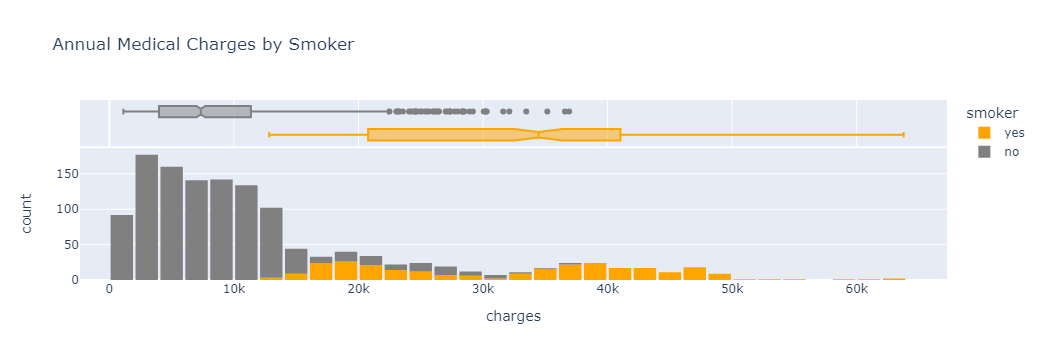

In [43]:
fig = px.histogram(medical_df, 
                   x='charges',
                   marginal='box', 
                   color='smoker',
                   color_discrete_sequence=['orange', 'grey'], 
                   title='Annual Medical Charges by Smoker')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.



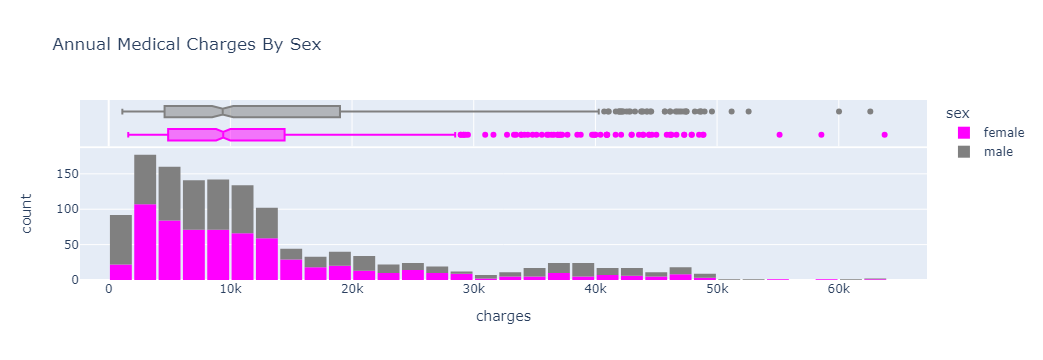

In [44]:
fig = px.histogram(medical_df, 
                   x='charges',
                   marginal='box', 
                   color='sex',
                   color_discrete_sequence=['magenta', 'grey'], 
                   title='Annual Medical Charges By Sex')
fig.update_layout(bargap=0.1)
fig.show()

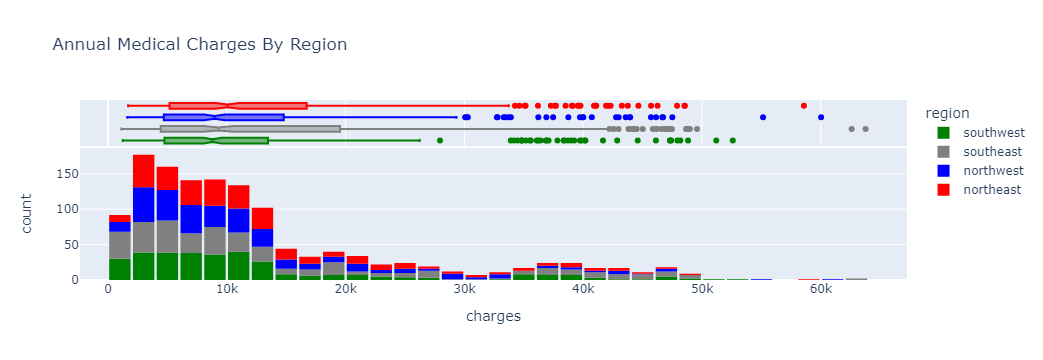

In [45]:
fig = px.histogram(medical_df, 
                   x='charges',
                   marginal='box', 
                   color='region',
                   color_discrete_sequence=['green', 'grey','blue','red'], 
                   title='Annual Medical Charges By Region')
fig.update_layout(bargap=0.1)
fig.show()

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram: to what extent does this feature contribute to charges?

In [46]:
medical_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

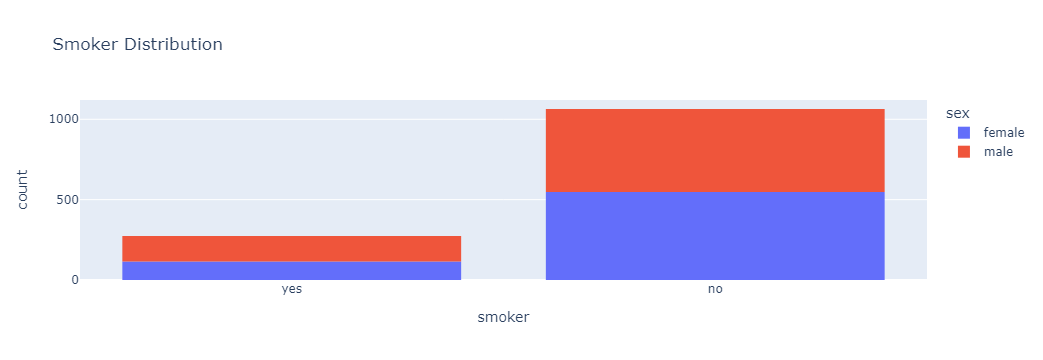

In [47]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker Distribution')

It appears that 20% of customers have reported that they smoke. We can verify this with the national average, assuming the data was collected in 2010? We can also see that smoking appears a more common habit among males.


Age and Charges
Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

### Correlation: Multivariate Analysis

From the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [48]:
medical_df.charges.corr(medical_df.age)

0.2990081933306477

In [49]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362887

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [50]:
smoker_vals  = {'no':0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_vals)

In [51]:
medical_df.charges.corr(smoker_numeric)

0.7872514304984773

The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

Text(0.5, 1.0, 'Correlation Matrix')

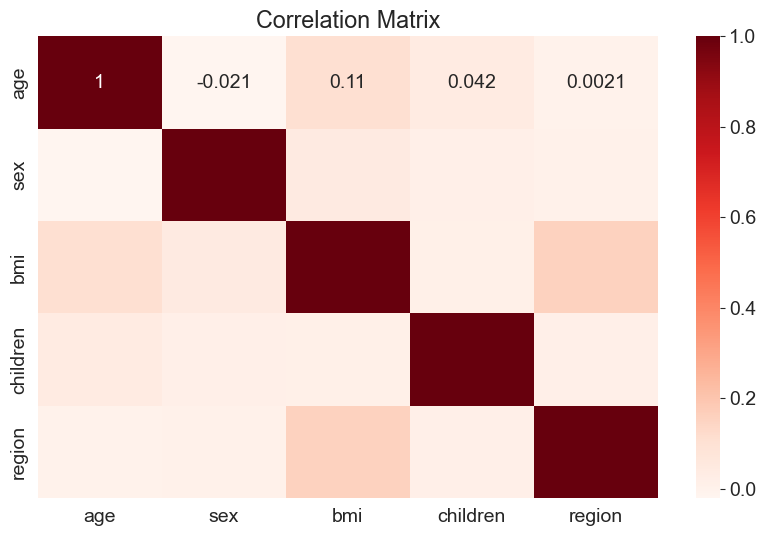

In [120]:
sns.heatmap(X.corr(), cmap='Reds', annot=True)
plt.title("Correlation Matrix")

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 

While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated system can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.

## Linear Regression using a Single Feature

We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

In [53]:
non_smoker_df = medical_df[medical_df.smoker =='no']

Next, let's visualize the relationship between "age" and "charges"

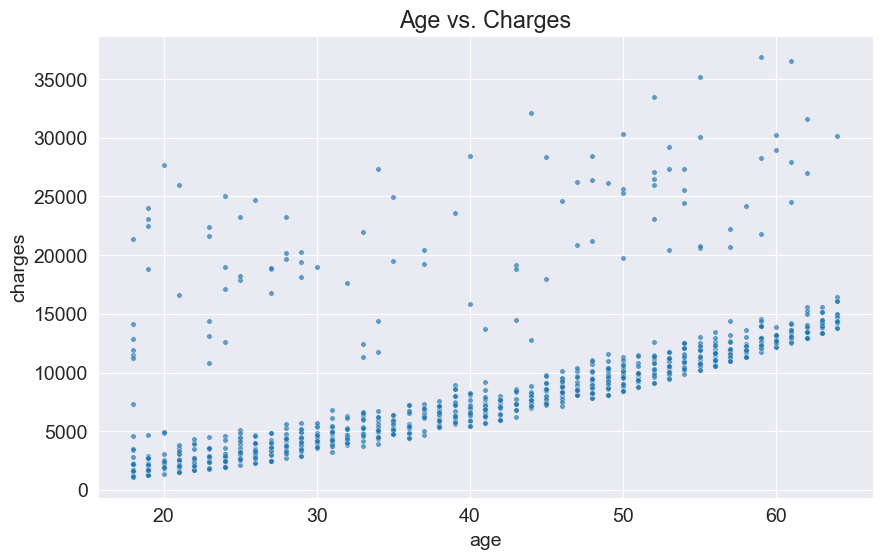

In [54]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

### RandomForest using Scikit-learn
The random forest uses many trees, and it makes a prediction by averaging the predictions of each component tree. It generally has much better predictive accuracy than a single decision tree and it works well with default parameters. If you keep modeling, you can learn more models with even better performance, but many of those are sensitive to getting the right parameters


In [55]:
!pip install scikit-learn --quiet

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [87]:
# Prepare and encode the data:
y = medical_df['charges']
X= medical_df[cols]
cols = ['age', 'sex', 'bmi', 'children', 'region']
print(medical_df[cols])

      age     sex     bmi  children     region
0      19  female  27.900         0  southwest
1      18    male  33.770         1  southeast
2      28    male  33.000         3  southeast
3      33    male  22.705         0  northwest
4      32    male  28.880         0  northwest
...   ...     ...     ...       ...        ...
1333   50    male  30.970         3  northwest
1334   18  female  31.920         0  northeast
1335   18  female  36.850         0  southeast
1336   21  female  25.800         0  southwest
1337   61  female  29.070         0  northwest

[1338 rows x 5 columns]


We first select training from test data to avoid "in sample score errors"

But first we need to converst all categoric to numerical variables


In [80]:
X.info() ['sex', 'region']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   region    1338 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 52.4+ KB


In [88]:
# we need to encode sex and region

In [96]:
# Encode 'sex' and 'region' columns using LabelEncoder
label_encoder = LabelEncoder()
X['sex']=label_encoder.fit_transform(X['sex'])
X['region']=label_encoder.fit_transform(X['region'])
X.apply(pd.to_numeric)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_10188\1322552530.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Andrew\AppData\Local\Temp\ipykernel_10188\1322552530.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,sex,bmi,children,region
0,19,0,27.900,0,3
1,18,1,33.770,1,2
2,28,1,33.000,3,2
3,33,1,22.705,0,1
4,32,1,28.880,0,1
...,...,...,...,...,...
1333,50,1,30.970,3,1
1334,18,0,31.920,0,0
1335,18,0,36.850,0,2
1336,21,0,25.800,0,3


In [101]:
type(X)

pandas.core.frame.DataFrame

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int32  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   region    1338 non-null   int32  
dtypes: float64(1), int32(2), int64(2)
memory usage: 41.9 KB


In [92]:
medical_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [103]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

## Predictions and Evaluation the model

In [121]:
model = RandomForestRegressor(random_state=1)
model.fit(train_X, train_y)
# predictions = model.predict(val_X)
predictions  = model.predict(val_X)
print("Model score: %.3f" % model.score(val_X, val_y))
# print(predictions)

Model score: 0.003


In [107]:
mae = mean_absolute_error(val_y, predictions)
print("Model Errror", mae)

Model Errror 9903.77214582597


## Observation
A model score (R² score) of 0.003 and a mean absolute error (MAE) of 9903.77 suggest that that the current model is not performing well. The R² score close to 0 means that the model explains almost none of the variance in the target variable, and a high MAE indicates that the predictions are far from the actual values.

In [113]:
# Let try fine tuning the model adjusting the tree depth
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [115]:
# here we compare different leaf sizes and keep the best: 
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

scores = {leafsize: get_mae(leafsize, train_X, val_X, train_y, val_y) for leafsize in candidate_max_leaf_nodes}

print(scores)

best_tree_size = min(scores, key=scores.get)
print(" \n Best Tree size is", best_tree_size)

{5: 9219.706410596285, 25: 9435.14005720838, 50: 9619.352534208108, 100: 9681.282115047892, 250: 9885.942558718414, 500: 9871.580674825487}
 
 Best Tree size is 5


In [116]:
## Having understood the best tree: let fit the final model with all the data 

In [122]:
final_model = RandomForestRegressor(max_leaf_nodes=best_tree_size)
final_model.fit(X,y)
val_pred1 =model.predict(val_X)
mae = mean_absolute_error(val_y,val_pred1 )
print(mae)

9903.77214582597


the current approach is still far from the actual values: 
Future Steps:
Cross-validation: Using cross-validation can provide a more reliable estimate of model performance.
Feature Importance: We will remove features non contributing features and scale for better results
Experiment with Different Models: We will implement different models like Gradient Boosting, XGBoost, or LightGBM to see if yield better results.